In [1]:
# Install Required Libraries
# !pip install tensorflow keras-tuner numpy scikit-learn matplotlib pillow
import sys
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install keras-tuner

In [2]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
import os

In [3]:
# Load and Preprocess Dataset
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

# Split training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

In [4]:
# Define a Model Builder for Hyperparameter Tuning
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(keras.Input(shape=(784,)))
    
    # Hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                activation='relu',
                kernel_regularizer=keras.regularizers.l2(hp.Choice('l2', [0.001, 0.0001]))
            )
        )
        model.add(
            keras.layers.Dropout(
                rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)
            )
        )
    
    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [5]:
# Perform Hyperparameter Tuning


# Remove previous tuning logs if they exist
if os.path.exists("my_dir/mnist_tuning"):
    shutil.rmtree("my_dir/mnist_tuning")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning'
)

# Start search
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# To recompile with a fresh optimizer
best_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

Trial 10 Complete [00h 00m 53s]
val_accuracy: 0.9035833477973938

Best val_accuracy So Far: 0.9748333096504211
Total elapsed time: 00h 09m 01s


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
# Evaluate and Use the Best Model
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9714 - loss: 0.1506    
Test accuracy: 0.9763


In [7]:
# Save the model
best_model.save('best_mnist_model.keras')



In [8]:
# Load later
model = keras.models.load_model('best_mnist_model.keras')

# Recompile the model to avoid optimizer loading warning
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# #Preprocess functions
def preprocess_user_image(path):
    # Load and convert to grayscale
    img = Image.open(path).convert('L')

    # Invert colors: white digit on black bg -> black digit on white bg (MNIST-style)
    img = ImageOps.invert(img)

    # Resize while keeping aspect ratio, add padding to make it square (28x28)
    img.thumbnail((20, 20), Image.Resampling.LANCZOS)
    delta_w = 28 - img.size[0]
    delta_h = 28 - img.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
    img_padded = ImageOps.expand(img, padding, fill=0)

    # Convert to numpy array, normalize
    img_array = np.array(img_padded).astype("float32") / 255.0

    # Flatten
    return img_array.reshape(1, 784), img_array


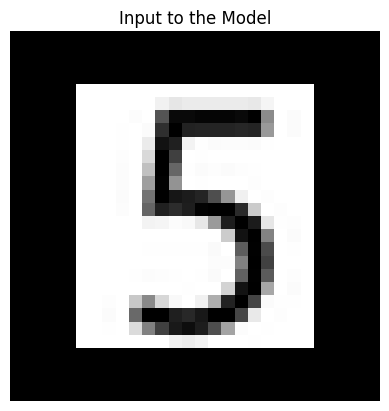

In [10]:
#
# Example usage
image_path = "input5.png"  # Replace with your image file
# input_data = preprocess_image(image_path)
input_data, vis_data = preprocess_user_image("input5.png")

plt.imshow(input_data.reshape(28, 28), cmap='gray')
plt.title("Input to the Model")
plt.axis('off')
plt.show()

In [11]:
# Print prediction probabilities:
probs = best_model.predict(input_data)
print("Class probabilities:", probs)
print("Predicted digit:", np.argmax(probs))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Class probabilities: [[1.53886378e-01 4.81084629e-04 8.80190637e-04 6.37510233e-03
  3.30696665e-02 5.30095279e-01 7.92985559e-02 6.74340967e-03
  6.80493191e-02 1.21121034e-01]]
Predicted digit: 5


In [12]:
#Predict
prediction = best_model.predict(input_data)
predicted_class = np.argmax(prediction)
print(f"Predicted digit: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted digit: 5


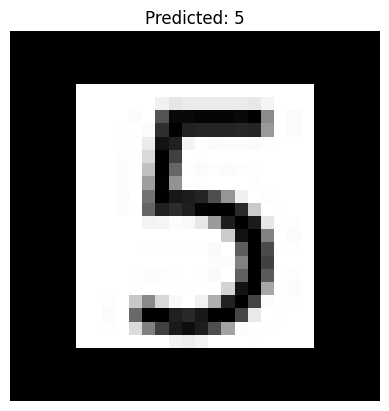

In [13]:
# # Optional: show image
# Visualize final input
plt.imshow(vis_data, cmap='gray')
plt.title(f"Predicted: {np.argmax(probs)}")
plt.axis('off')
plt.show()

In [14]:
#
